# Setup

In [508]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error as mse

In [509]:
ROOT = "/content"
data_file = os.path.join(ROOT, "data/Task3and4_Loan_Data.csv")
if not os.path.exists(data_file):
    print("File not found")
    sys.exit(1)

df = pd.read_csv(data_file)

# Data Processing (Train, Val, Test)

In [510]:
# All features
features = ['fico_score']
target = 'default'

# binary target (default = 1, no default = 0)
X, y = df[features], df[target]

# not going to use validation and test data here

# universal variables
MIN_SCORE, MAX_SCORE = 300, 850
RANGE_FICO = MAX_SCORE - MIN_SCORE

X.head(5)

,fico_score
0,605
1,572
2,602
3,612
4,631


# Fico Score Bucketing

## Strategy: Minimize Mean Squared Error (MSE)

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( Y_i - \hat{Y_i} \right)^2
$$

Where:
- $n$ is the number of borrowers
- $Y_i$ is the observed/true value (credit score)
- $\hat{Y_i}$ is the predicted value (mean of credit score bucket)

In [511]:
NUM_BUCKETS = 10

bucket_size = RANGE_FICO // NUM_BUCKETS
bucket_size_mid = bucket_size / 2

# Y hat can be average of scores in bucket or midpoint of bucket range
# we don't see any scores in bucket 0 because our min score is 409 and 300-354 is below that
# 355-409 (bucket #1) captures the min score in our training data
X['bucket_num'] = ((X['fico_score'] - MIN_SCORE) // bucket_size).astype(int)

# Handle the edge case where FICO score is exactly max_score (850) (put in highest bucket)
X.loc[X['fico_score'] == MAX_SCORE, 'bucket_num'] = NUM_BUCKETS - 1

# we don't need this twice, but easier when next to other vars
X['y_true'] = X['fico_score']

X['y_hat_midp'] = X['bucket_num'] * bucket_size + bucket_size_mid + MIN_SCORE

X['delta_y_midp'] = X['y_hat_midp'] - X['y_true']

X['delta_y_sq_midp'] = X['delta_y_midp'] ** 2

# what is the mean fico score for all scores in that bucket? and update all the rows accordingly
X['y_hat_mean'] = X.groupby('bucket_num')['fico_score'].transform('mean')

X['delta_y_mean'] = X['y_hat_mean'] - X['fico_score']

X['delta_y_sq_mean'] = X['delta_y_mean'] ** 2

# sort by bucket num ascending
X = X.sort_values(by='bucket_num')

X.head(5)

,fico_score,bucket_num,y_true,y_hat_midp,delta_y_midp,delta_y_sq_midp,y_hat_mean,delta_y_mean,delta_y_sq_mean
2092,408,1,408,382.5,-25.5,650.25,408.500000,0.500000,0.250000
6556,409,1,409,382.5,-26.5,702.25,408.500000,-0.500000,0.250000
2896,450,2,450,437.5,-12.5,156.25,451.923077,1.923077,3.698225
1659,462,2,462,437.5,-24.5,600.25,451.923077,-10.076923,101.544379
3604,455,2,455,437.5,-17.5,306.25,451.923077,-3.076923,9.467456


#### Bucket #0 is not occupied since our min score is 408 and that falls in the upper edge of bucket #1. Having an empty buckets suggests that there could be a better way of binning the fico scores.

In [512]:
MSE_X_midp = mse(X['y_true'], X['y_hat_midp'])
print(f"MSE for X_train using bucket midpoint as predicted value: {MSE_X_midp}")

MSE_X_mean = mse(X['y_true'], X['y_hat_mean'])
print(f"MSE for X_train using bucket average as predicted value: {MSE_X_mean}")

MSE for X_train using bucket midpoint as predicted value: 253.56
MSE for X_train using bucket average as predicted value: 236.84477824394568


#### We did the unsophisticated calculation of mean squared error, and it is high. Taking the average of the scores in a bucket outperforms the midpoint of the bucket's range by around 6%.

#### We will try more sophisticated methods to attempt to reduce the error of fico scores next.

## Strategy: Maximize Log-likelihood function

Log-likelihood
$$
LL(b_1, \ldots, b_{r-1}) = \sum_{i=1}^r \left[k_i \ln p_i + (n_i - k_i) \ln(1 - p_i)\right]
$$

Where:
- $b_i$ is the bucket boundaries,
- $n_i$ is the number of records in each bucket,
- $k_i$ is the number of defaults in each bucket, and
- $p_i = \frac{k_i}{n_i}$ is the probability of default in the bucket.

In [513]:
NUM_BUCKETS = 10

bucket_size = RANGE_FICO // NUM_BUCKETS
bucket_size_mid = bucket_size / 2

# Check bucket boundaries for debugging
bucket_lower_bounds = [ x * bucket_size + MIN_SCORE for x in range(NUM_BUCKETS) ]
bucket_upper_bounds = [ x * bucket_size + MIN_SCORE + bucket_size - 1 for x in range(NUM_BUCKETS) ]
bucket_upper_bounds[-1] = MAX_SCORE
# print(f"Bucket lower boundaries: {bucket_lower_bounds}")

df_temp = pd.DataFrame(columns=['fico_score', 'default', 'bucket_num'],
                        index=X.index)
df_temp['fico_score'] = X['fico_score']
df_temp['default'] = y
df_temp['bucket_num'] = X['bucket_num']

df_temp.sort_values(by=['bucket_num', 'fico_score'], inplace=True)
df_temp

,fico_score,default,bucket_num
2092,408,0,1
6556,409,1,1
7001,418,1,2
5521,425,1,2
2629,438,1,2
...,...,...,...
703,828,0,9
4768,831,0,9
7575,831,0,9
9660,835,0,9


In [514]:
buckets = [ x for x in range(NUM_BUCKETS) ]
df_log = pd.DataFrame(columns=['bucket_num', 'score_range', 'k', 'n', 'p', 'log_likelihood'],
                      index=buckets)

# # may or may not have fico scores in each bucket
df_log['bucket_num'] = buckets
df_log['score_range'] = \
    df_log['bucket_num'].apply(lambda x: f"{bucket_lower_bounds[x]} - {bucket_upper_bounds[x]}")

# # k_i = num defaulting borrowers in each bucket b_i
df_log['k'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 1).sum())
df_log['k'] = df_log['k'].fillna(0).astype(int) # counts always integers

# # n_i = num total borrowers in each bucket b_i
df_log['n'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 0).sum())
df_log['n'] += df_log['k'] # add defaults to non defaults for total
df_log['n'] = df_log['n'].fillna(0).astype(int) # counts always integers

# p_i = k_i / n_i = default rate per bucket b_i
df_log['p'] = df_log['k'] / df_log['n']

# log likelihood (see formula above)
df_log['log_likelihood'] = df_log['k'] * np.log( df_log['p'] ) \
    + ( df_log['n'] - df_log['k'] ) * np.log( 1 - df_log['p'] )

# make every value be 0 in case there are empty buckets
df_log = df_log.fillna(0)

total_log_likelihood = df_log['log_likelihood'].sum()
print(f"Total Log-Likelihood: {total_log_likelihood}")

df_log.head(10)

Total Log-Likelihood: -4282.770221919642


,bucket_num,score_range,k,n,p,log_likelihood
0,0,300 - 354,0,0,0.000000,0.000000
1,1,355 - 409,1,2,0.500000,-1.386294
2,2,410 - 464,18,26,0.692308,-16.048286
3,3,465 - 519,173,263,0.657795,-168.974194
4,4,520 - 574,464,1188,0.390572,-794.776082
5,5,575 - 629,647,2941,0.219993,-1549.611001
6,6,630 - 684,420,3374,0.124481,-1267.813027
7,7,685 - 739,115,1775,0.064789,-425.903193
8,8,740 - 794,12,386,0.031088,-53.462677
9,9,795 - 850,1,45,0.022222,-4.795468


#### Having fewer buckets may capture the data better since bucket #0 has no borrowers, and buckets #1 and #9 only have 1 borrower.
#### Values close to 0 suggest unlikely to default, and the uniform distribution is not representative of the p - default percentage in a bucket.

In [515]:
NUM_BUCKETS = 5

bucket_size = RANGE_FICO // NUM_BUCKETS
bucket_size_mid = bucket_size / 2

# Y hat can be average of scores in bucket or midpoint of bucket range
# we don't see any scores in bucket 0 because our min score is 409 and 300-354 is below that
# 355-409 (bucket #1) caputures the min score in our training data
X['bucket_num'] = ((X['fico_score'] - MIN_SCORE) // bucket_size).astype(int)

# Handle the edge case where FICO score is exactly max_score (850) (put in highest bucket)
X.loc[X['fico_score'] == MAX_SCORE, 'bucket_num'] = NUM_BUCKETS - 1

# Check bucket boundaries for debugging
bucket_lower_bounds = [ x * bucket_size + MIN_SCORE for x in range(NUM_BUCKETS) ]
bucket_upper_bounds = [ x * bucket_size + MIN_SCORE + bucket_size - 1 for x in range(NUM_BUCKETS) ]
bucket_upper_bounds[-1] = MAX_SCORE
# print(f"Bucket lower boundaries: {bucket_lower_bounds}")

df_temp = pd.DataFrame(columns=['fico_score', 'default', 'bucket_num'],
                       index=X.index)
df_temp['fico_score'] = X['fico_score']
df_temp['default'] = y
df_temp['bucket_num'] = X['bucket_num']

df_temp.sort_values(by=['bucket_num', 'fico_score'], inplace=True)
df_temp

,fico_score,default,bucket_num
2092,408,0,0
6556,409,1,0
7001,418,1,1
5521,425,1,1
2629,438,1,1
...,...,...,...
703,828,0,4
4768,831,0,4
7575,831,0,4
9660,835,0,4


In [516]:
buckets = [ x for x in range(NUM_BUCKETS) ]
df_log = pd.DataFrame(columns=['bucket_num', 'score_range', 'k', 'n', 'p', 'log_likelihood'],
                      index=buckets)

# # may or may not have fico scores in each bucket
df_log['bucket_num'] = buckets
df_log['score_range'] = \
    df_log['bucket_num'].apply(lambda x: f"{bucket_lower_bounds[x]} - {bucket_upper_bounds[x]}")

# # k_i = num defaulting borrowers in each bucket b_i
df_log['k'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 1).sum())
df_log['k'] = df_log['k'].fillna(0).astype(int) # counts always integers

# # n_i = num total borrowers in each bucket b_i
df_log['n'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 0).sum())
df_log['n'] += df_log['k'] # add defaults to non defaults for total
df_log['n'] = df_log['n'].fillna(0).astype(int) # counts always integers

# p_i = k_i / n_i = default rate per bucket b_i
df_log['p'] = df_log['k'] / df_log['n']

# log likelihood (see formula above)
df_log['log_likelihood'] = df_log['k'] * np.log( df_log['p'] ) \
    + ( df_log['n'] - df_log['k'] ) * np.log( 1 - df_log['p'] )

# make every value be 0 in case there are empty buckets
df_log = df_log.fillna(0)

# total log likelihood
total_log_likelihood = df_log['log_likelihood'].sum()
print(f"Total Log-Likelihood: {total_log_likelihood}")

# View df_log to debug
df_log

Total Log-Likelihood: -4366.832382085044


,bucket_num,score_range,k,n,p,log_likelihood
0,0,300 - 409,1,2,0.500000,-1.386294
1,1,410 - 519,191,289,0.660900,-185.086275
2,2,520 - 629,1111,4129,0.269072,-2404.457328
3,3,630 - 739,535,5149,0.103904,-1717.585479
4,4,740 - 850,13,431,0.030162,-58.317006


#### This looks to be on the right track with the top bucket having 7 defaults and 260 total borrowers. The bottom bucket only has once value; however, so it would be worth widening the buckets to capture more low fico scores. Since I use the hard limit of 300 and no one applied for loans with scores under 400, we could adjust the lower limit upwards - but it would not be versatile with unseen data and scores lower than our min of 409.

In [517]:
NUM_BUCKETS = 3

bucket_size = RANGE_FICO // NUM_BUCKETS
bucket_size_mid = bucket_size / 2

# Y hat can be average of scores in bucket or midpoint of bucket range
# we don't see any scores in bucket 0 because our min score is 409 and 300-354 is below that
# 355-409 (bucket #1) caputures the min score in our training data
X['bucket_num'] = ((X['fico_score'] - MIN_SCORE) // bucket_size).astype(int)

# Handle the edge case where FICO score is exactly max_score (850) (put in highest bucket)
X.loc[X['fico_score'] == MAX_SCORE, 'bucket_num'] = NUM_BUCKETS - 1

# Check bucket boundaries for debugging
bucket_lower_bounds = [ x * bucket_size + MIN_SCORE for x in range(NUM_BUCKETS) ]
bucket_upper_bounds = [ x * bucket_size + MIN_SCORE + bucket_size - 1 for x in range(NUM_BUCKETS) ]
bucket_upper_bounds[-1] = MAX_SCORE
# print(f"Bucket lower boundaries: {bucket_lower_bounds}")

df_temp = pd.DataFrame(columns=['fico_score', 'default', 'bucket_num'],
                       index=X.index)
df_temp['fico_score'] = X['fico_score']
df_temp['default'] = y
df_temp['bucket_num'] = X['bucket_num']

df_temp.sort_values(by=['bucket_num', 'fico_score'], inplace=True)
df_temp

,fico_score,default,bucket_num
2092,408,0,0
6556,409,1,0
7001,418,1,0
5521,425,1,0
2629,438,1,0
...,...,...,...
703,828,0,2
4768,831,0,2
7575,831,0,2
9660,835,0,2


In [518]:
buckets = [ x for x in range(NUM_BUCKETS) ]
df_log = pd.DataFrame(columns=['bucket_num', 'score_range', 'k', 'n', 'p', 'log_likelihood'],
                      index=buckets)

# # may or may not have fico scores in each bucket
df_log['bucket_num'] = buckets
df_log['score_range'] = \
    df_log['bucket_num'].apply(lambda x: f"{bucket_lower_bounds[x]} - {bucket_upper_bounds[x]}")

# # k_i = num defaulting borrowers in each bucket b_i
df_log['k'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 1).sum())
df_log['k'] = df_log['k'].fillna(0).astype(int) # counts always integers

# # n_i = num total borrowers in each bucket b_i
df_log['n'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 0).sum())
df_log['n'] += df_log['k'] # add defaults to non defaults for total
df_log['n'] = df_log['n'].fillna(0).astype(int) # counts always integers

# p_i = k_i / n_i = default rate per bucket b_i
df_log['p'] = df_log['k'] / df_log['n']

# log likelihood (see formula above)
df_log['log_likelihood'] = df_log['k'] * np.log( df_log['p'] ) \
    + ( df_log['n'] - df_log['k'] ) * np.log( 1 - df_log['p'] )

# make every value be 0 in case there are empty buckets
df_log = df_log.fillna(0)

# total log likelihood
total_log_likelihood = df_log['log_likelihood'].sum()
print(f"Total Log-Likelihood: {total_log_likelihood}")

# View df_log to debug
df_log

Total Log-Likelihood: -4512.5490449615545


,bucket_num,score_range,k,n,p,log_likelihood
0,0,300 - 482,48,68,0.705882,-41.194230
1,1,483 - 665,1576,6673,0.236176,-3647.671460
2,2,666 - 850,227,3259,0.069653,-823.683355


#### The high credit scores should not be more likley to default than the middle group (looking at p_i, the default percentage). The closer to 0 for log likelihood, the more likely the event (default). Therefore, since log likelihood is influenced by the n_i number of borrowers, we should aim to have similar amounts of borrowers in each bucket to get comparable log likelihood results.

## Dynamic programming to create buckets of similar sizes

In [519]:
X, y = df[features], df[target]

# create 10 buckets, each with approx 1/10 of the training data
# scores distribution likely to vary a decent amount
NUM_BUCKETS = 10
min_score, max_score = 300, 850
# b_i : lower score, upper score, count of borrowers in bucket b_i
bucket_dict = {}

def bin_scores(lower_score_bound,
               delta,
               df_borrowers: pd.DataFrame,
               bucket_id,
               num_buckets):
    """
    create buckets of approx the same amount of borrowers, and
    say the score range for each of the buckets
    """
    # exit conditions
    if bucket_id >= num_buckets or lower_score_bound >= max_score:
        return

    # final bucket: all remaining borrowers into this one
    if bucket_id == num_buckets - 1:
        borrowers_left = df_borrowers.shape[0]
        for _, value in bucket_dict.items():
            borrowers_left -= value['count']

        bucket_dict[bucket_id] = ({
            'lower_score_bound': lower_score_bound,
            'upper_score_bound': max_score,
            'count': borrowers_left
        })
        bin_scores(max_score, 0, df_borrowers, bucket_id + 1, num_buckets)

    # target num of borrowers per bucket
    # use delta to normalize bucket sizes
    # many borrowers had x score which pushed total above 600 for example
    target_count = (df_borrowers.shape[0] // num_buckets) + delta
    bucket_total = 0

    lp, rp = lower_score_bound, max_score
    while lp < rp:
        if bucket_total < target_count:
            # add num of borrowers with lp (score) to the bucket_total
            bucket_total += (df_borrowers['fico_score'] == lp).sum()

        if bucket_total >= target_count:
            bucket_dict[bucket_id] = ({
                'lower_score_bound': lower_score_bound,
                'upper_score_bound': lp,
                'count': bucket_total
            })
            bin_scores(lp+1, target_count - bucket_total,
                        df_borrowers, bucket_id + 1, num_buckets)
            lp = rp
        lp += 1


bin_scores(min_score, 0, X, 0, NUM_BUCKETS)

_ = [ print(f'bucket #{k}: {v}') for k,v in bucket_dict.items() ]

bucket #0: {'lower_score_bound': 300, 'upper_score_bound': 560, 'count': 1017}
bucket #1: {'lower_score_bound': 561, 'upper_score_bound': 587, 'count': 1033}
bucket #2: {'lower_score_bound': 588, 'upper_score_bound': 607, 'count': 987}
bucket #3: {'lower_score_bound': 608, 'upper_score_bound': 623, 'count': 984}
bucket #4: {'lower_score_bound': 624, 'upper_score_bound': 638, 'count': 992}
bucket #5: {'lower_score_bound': 639, 'upper_score_bound': 653, 'count': 997}
bucket #6: {'lower_score_bound': 654, 'upper_score_bound': 670, 'count': 1027}
bucket #7: {'lower_score_bound': 671, 'upper_score_bound': 688, 'count': 970}
bucket #8: {'lower_score_bound': 689, 'upper_score_bound': 714, 'count': 1005}
bucket #9: {'lower_score_bound': 715, 'upper_score_bound': 850, 'count': 988}


#### Equal fico score splits for bucket ranges are easy to read but produced poor risk scoring and distribution.
#### I made this dynamic program to have flexible score bands but approximately equal scores per bucket.
#### It does not guarantee perfectly even buckets (for example if there are 990 borrowers in the lowest bucket and we see at score 560 there are 27 matches, that entire group will go to the current bucket).
#### To prevent the last bucket from having a lower expected value than n / num_buckets, I calculated a delta which I carried forward into the next recursion layer. The target amount for the current bucket would be lower, offsetting the greedier previous bucket.
#### The last bucket by default takes all remaining borrowers - no math necessary.
#### Let's see if the log-likelihood scores reflect default rate now.

In [520]:
df_dynamic_buckets = pd.DataFrame(columns=['bucket_num', 'count', 'score_range'],
                               index=sorted(bucket_dict.keys()))
df_dynamic_buckets['bucket_num'] = bucket_dict.keys()
df_dynamic_buckets['count'] = df_dynamic_buckets['bucket_num'].apply(lambda x: bucket_dict[x]['count'])
df_dynamic_buckets['score_range'] = \
    df_dynamic_buckets['bucket_num'].apply(lambda x: f"{bucket_dict[x]['lower_score_bound']} - {bucket_dict[x]['upper_score_bound']}")
df_dynamic_buckets['midp'] = df_dynamic_buckets['bucket_num'].apply(lambda x: (bucket_dict[x]['lower_score_bound'] + bucket_dict[x]['upper_score_bound']) / 2)

# apply our count rules on the X_train_60pct to assign buckets and calc log likelihood
df_temp = pd.DataFrame(columns=['fico_score', 'default', 'bucket_num'],
                       index=X.index)
df_temp['fico_score'] = X['fico_score']
df_temp['default'] = y
# use dynamic df lower and upper bound on df temp scores to bucketize
for score in df_temp['fico_score']:
    for bucket_num, bucket in bucket_dict.items():
        if bucket['lower_score_bound'] <= score <= bucket['upper_score_bound']:
            df_temp.loc[df_temp['fico_score'] == score, 'bucket_num'] = bucket_num
            break

# Log Likelihood
df_dynamic_buckets['k'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 1).sum())
df_dynamic_buckets['k'] = df_dynamic_buckets['k'].fillna(0).astype(int) # counts always integers

df_dynamic_buckets['n'] = df_temp.groupby('bucket_num')['default'].apply(lambda x: (x == 0).sum())
df_dynamic_buckets['n'] += df_dynamic_buckets['k'] # add defaults to non defaults for total
df_dynamic_buckets['n'] = df_dynamic_buckets['n'].fillna(0).astype(int) # counts always integers

df_dynamic_buckets['p'] = df_dynamic_buckets['k'] / df_dynamic_buckets['n']

df_dynamic_buckets['log_likelihood'] = df_dynamic_buckets['k'] * np.log( df_dynamic_buckets['p'] ) \
    + ( df_dynamic_buckets['n'] - df_dynamic_buckets['k'] ) * np.log( 1 - df_dynamic_buckets['p'] )

# make pos, % 100, use max score as scaled max score, apply scaling from 0.0 to 10.0
df_dynamic_buckets['Rating'] = abs(df_dynamic_buckets['log_likelihood']) / 100
df_dynamic_buckets['Rating'] = round(df_dynamic_buckets['Rating'] / df_dynamic_buckets['Rating'].max() * 10, 1)

# make every value be 0 in case there are empty buckets
df_dynamic_buckets = df_dynamic_buckets.fillna(0)

total_log_likelihood = df_dynamic_buckets['log_likelihood'].sum()
print(f"Total Log-Likelihood: {total_log_likelihood}")

df_dynamic_buckets

Total Log-Likelihood: -4267.901398927441


,bucket_num,count,score_range,midp,k,n,p,log_likelihood,Rating
0,0,1017,300 - 560,430.0,499,1017,0.490659,-704.753190,10.0
1,1,1033,561 - 587,574.0,318,1033,0.307841,-637.735453,9.0
2,2,987,588 - 607,597.5,246,987,0.249240,-554.199308,7.9
3,3,984,608 - 623,615.5,179,984,0.181911,-466.689790,6.6
4,4,992,624 - 638,631.0,173,992,0.174395,-459.085012,6.5
5,5,997,639 - 653,646.0,128,997,0.128385,-382.155468,5.4
6,6,1027,654 - 670,662.0,108,1027,0.105161,-345.355816,4.9
7,7,970,671 - 688,679.5,92,970,0.094845,-304.198931,4.3
8,8,1005,689 - 714,701.5,72,1005,0.071642,-259.154522,3.7
9,9,988,715 - 850,782.5,36,988,0.036437,-154.573910,2.2


#### Now that sizing doesn't interfere with our log-likelihood scores, we can compare them objectively. The 10 buckets all have roughly 1,000 borrowers of the 10,000 in total.
#### Bucket #0 has a large score range of 260 points which we can guess is due to people with those credit scores choosing not to apply for loans, or even those scores not being very common. That constrasts with the large batches of scores in the 600's, where the majority of the borrowers have ratings at.
#### Again at the top tail end, scores above 715 become more rare.
#### The higher the negative value of log-likelihood, the more likely a borrower is to default, and this now falls in line with our expectations that the lower the credit score, the higher the rate of default.
#### Since our assignement is to give a rating to the borrowers, with higher values indicating higher default probability, I took the absolute value of the log likelihood, then scaled the values with the max risk being at 10.0.


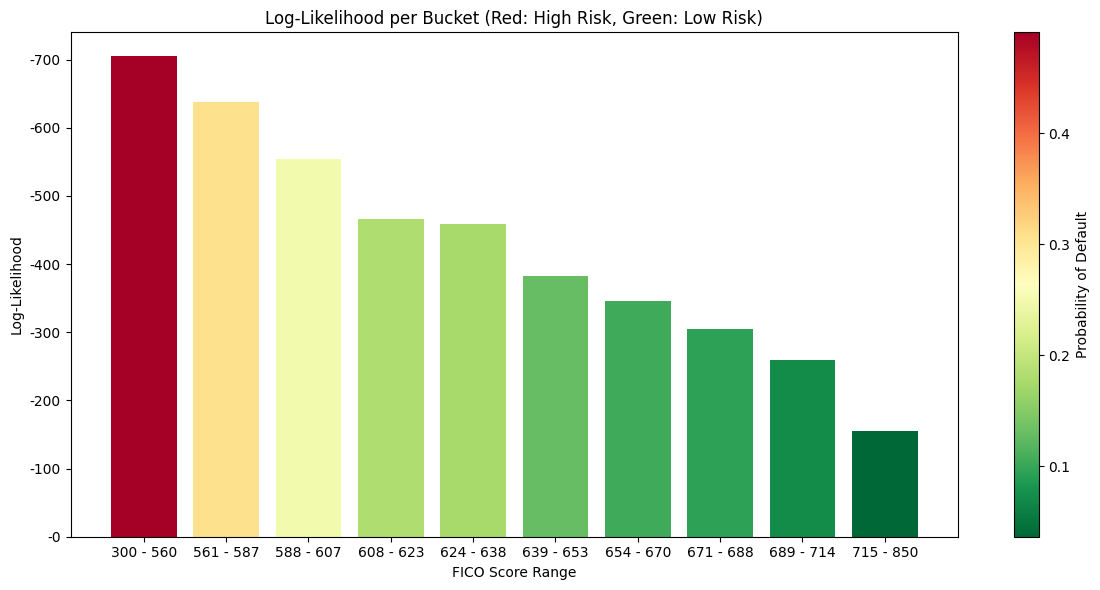

In [521]:
norm = plt.Normalize(df_dynamic_buckets['p'].min(), df_dynamic_buckets['p'].max())
colors = plt.cm.RdYlGn_r(norm(df_dynamic_buckets['p']))  # Use 'RdYlGn_r' for red to green shading

# Create the bar plot with log-likelihood on the y-axis
plt.figure(figsize=(12, 6))
bars = plt.bar(df_dynamic_buckets['score_range'], -df_dynamic_buckets['log_likelihood'], color=colors)

# Add color shading based on the default probabilities
for bar, p in zip(bars, df_dynamic_buckets['p']):
    bar.set_facecolor(plt.cm.RdYlGn_r(norm(p)))

# Add labels and title
plt.xlabel('FICO Score Range')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood per Bucket (Red: High Risk, Green: Low Risk)')

# Add color bar to show the gradient scale from low to high risk
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Probability of Default')


plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{-x:.0f}'))

plt.tight_layout()
plt.show()

#### This is a visual showing risk of default based on credit score band. Using the red and green shading, people can understand that low scores mean more likely to default without the need to go deep into understanding log-likelihood.